In [1]:
%load_ext rich

import matplotlib.pyplot as plt
import numpy as np
import optuna
import shap
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import cross_validate, train_test_split

sns.set_context("notebook")
sns.set_palette("colorblind")

In [2]:
df = pd.read_parquet("heloc.parquet")
y_0 = np.array(df.pop("target"))
x_0 = np.array(df)

In [3]:
# Hold out 10% of the data for evaluation
df_train, df_eval, y_train, y_eval = train_test_split(df, y_0, test_size=0.1, random_state=424)

print(f"Training data shape: {df_train.shape}")
print(f"Evaluation data shape: {df_eval.shape}")

Training data shape: (9413, 27)
Evaluation data shape: (1046, 27)


In [4]:
# Baseline with defaults
base_gbm = xgb.XGBClassifier()
print(cross_validate(base_gbm, x_0, y_0, scoring="roc_auc", cv=5, n_jobs=5)["test_score"].mean())

0.7432734999647466


In [5]:
# Optuna hyperparameter optimization - two step

def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": 100,
    }

    # maximum depth of the tree, signifies complexity of the tree.
    param["max_depth"] = trial.suggest_int("max_depth", 1, 10, step=1)
    # minimum child weight, larger the term more conservative the tree.
    param["gamma"] = trial.suggest_float("gamma", 0, 1)

    param["scale_pos_weight"] = trial.suggest_float("scale_pos_weight", 0.5, 2.0)

    param["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.2, 1.0)

    bst = xgb.XGBClassifier(**param)
    bst.fit(df_train, y_train)
    preds = bst.predict_proba(df_eval)[:, 1]
    auc = roc_auc_score(y_eval, preds)
    return auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=800, timeout=600, n_jobs=5)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-07 19:29:34,654] A new study created in memory with name: no-name-26f59b36-fd07-4c2c-b240-bc95963e4c63
[I 2024-11-07 19:29:35,414] Trial 3 finished with value: 0.7970861548383315 and parameters: {'max_depth': 1, 'gamma': 0.06636819679692707, 'scale_pos_weight': 0.6004940139355112, 'colsample_bytree': 0.7393226510606341}. Best is trial 3 with value: 0.7970861548383315.
[I 2024-11-07 19:29:35,829] Trial 1 finished with value: 0.7862618356638231 and parameters: {'max_depth': 6, 'gamma': 0.7239941686274599, 'scale_pos_weight': 1.597255846499745, 'colsample_bytree': 0.38639138786328564}. Best is trial 3 with value: 0.7970861548383315.
[I 2024-11-07 19:29:36,312] Trial 5 finished with value: 0.7845286254507079 and parameters: {'max_depth': 3, 'gamma': 0.24340671294677074, 'scale_pos_weight': 1.3322140906888338, 'colsample_bytree': 0.6559084583887138}. Best is trial 3 with value: 0.7970861548383315.
[I 2024-11-07 19:29:36,531] Trial 4 finished with value: 0.7791824231231496 and par

Number of finished trials:  800
Best trial:
  Value: 0.8024946501333803
  Params: 
    max_depth: 2
    gamma: 0.7014262080363415
    scale_pos_weight: 0.8550017682144365
    colsample_bytree: 0.8585696608750255


In [6]:
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "max_depth": study.best_trial.params["max_depth"],
        "gamma": study.best_trial.params["gamma"],
        "scale_pos_weight": study.best_trial.params["scale_pos_weight"],
        "colsample_bytree": study.best_trial.params["colsample_bytree"],
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0)
    }

    bst = xgb.XGBClassifier(**param)
    bst.fit(df_train, y_train)
    preds = bst.predict_proba(df_eval)[:, 1]
    return roc_auc_score(y_eval, preds)

study_2 = optuna.create_study(direction="maximize")
study_2.optimize(objective, n_trials=400, timeout=600, n_jobs=5)

print("Number of finished trials: ", len(study_2.trials))
print("Best trial:")
trial = study_2.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-11-07 19:33:31,243] A new study created in memory with name: no-name-e5abad4f-a689-43c2-b5e9-96f7ffe38bdc
[I 2024-11-07 19:33:32,898] Trial 2 finished with value: 0.797104476299358 and parameters: {'n_estimators': 650, 'reg_alpha': 0.8805157879430988}. Best is trial 2 with value: 0.797104476299358.
[I 2024-11-07 19:33:33,001] Trial 4 finished with value: 0.8000395743558174 and parameters: {'n_estimators': 550, 'reg_alpha': 0.7020270450364658}. Best is trial 4 with value: 0.8000395743558174.
[I 2024-11-07 19:33:33,446] Trial 5 finished with value: 0.7973133409550611 and parameters: {'n_estimators': 100, 'reg_alpha': 0.6721047467866902}. Best is trial 4 with value: 0.8000395743558174.
[I 2024-11-07 19:33:33,771] Trial 1 finished with value: 0.8005049394658927 and parameters: {'n_estimators': 600, 'reg_alpha': 0.7838055149126396}. Best is trial 1 with value: 0.8005049394658927.
[I 2024-11-07 19:33:34,028] Trial 3 finished with value: 0.8001568317063876 and parameters: {'n_estimato

Number of finished trials:  400
Best trial:
  Value: 0.8040941136810014
  Params: 
    n_estimators: 50
    reg_alpha: 0.006318153589900094


In [7]:
best_params = study.best_params
best_params.update(study_2.best_params)
best_params


{
    'max_depth': 2,
    'gamma': 0.7014262080363415,
    'scale_pos_weight': 0.8550017682144365,
    'colsample_bytree': 0.8585696608750255,
    'n_estimators': 50,
    'reg_alpha': 0.006318153589900094
}

In [8]:
# Fit on everything
xgb_best = xgb.XGBClassifier(**best_params)
xgb_best.fit(df_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8585696608750255, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.7014262080363415,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
print(f"ROC AUC: {roc_auc_score(y_eval, xgb_best.predict_proba(df_eval)[:, 1])}")

ROC AUC: 0.8040941136810014


In [10]:
explainer = shap.Explainer(xgb_best)
shap_values = explainer(df_eval)

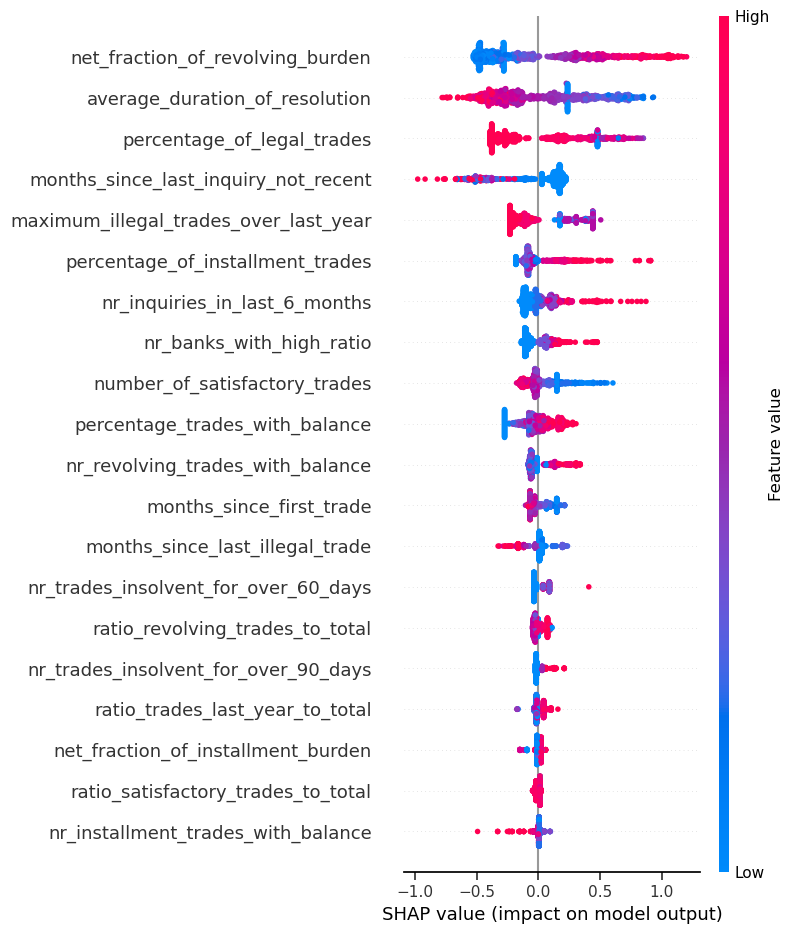

In [11]:
shap.summary_plot(shap_values, df_eval)

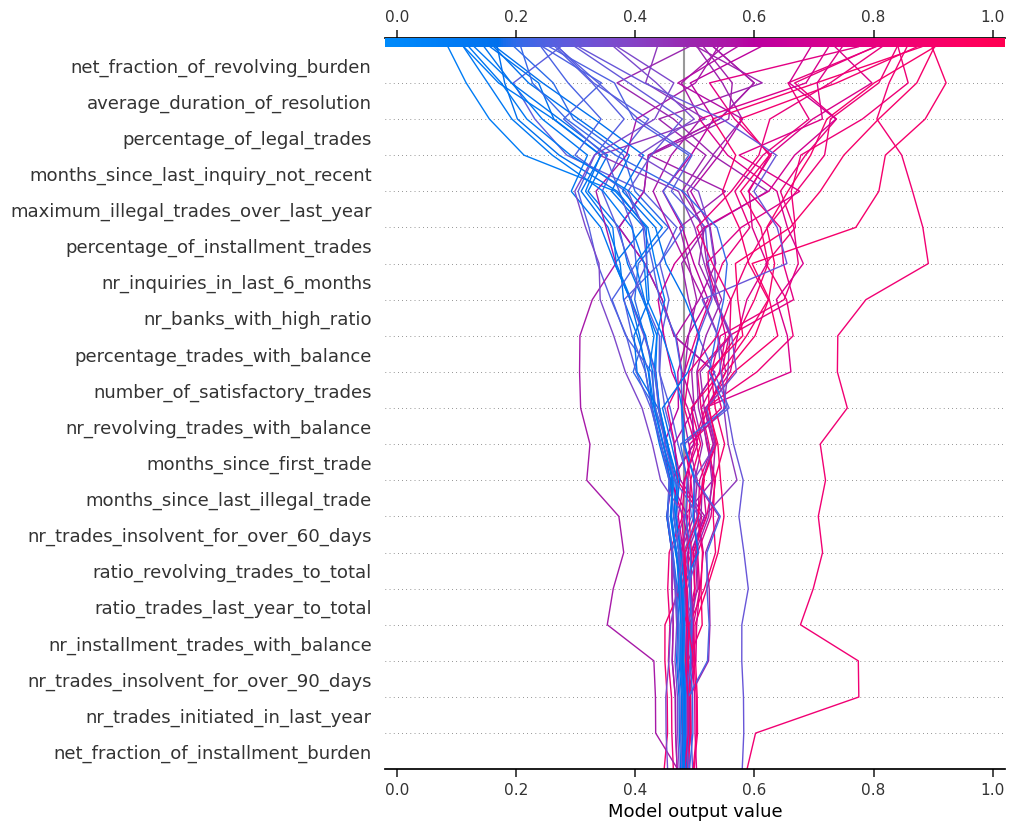

In [12]:
df_small = df_eval.sample(50)
shap.decision_plot(explainer.expected_value, explainer.shap_values(df_small), df_small.columns, link="logit")

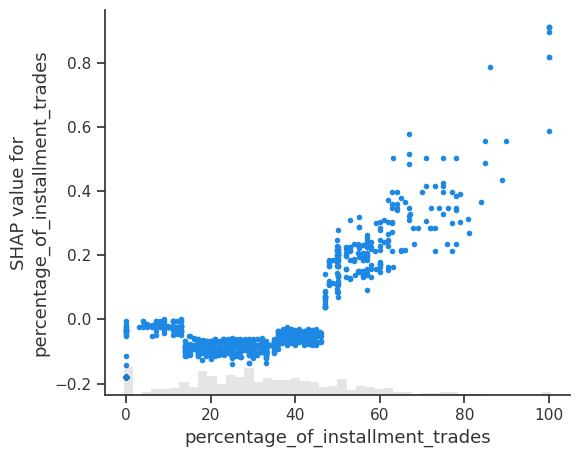

In [13]:
shap.plots.scatter(shap_values[:, "percentage_of_installment_trades"])

In [ ]:
import re

trees = xgb_best.get_booster().get_dump()
install_trees = [t for t in trees if "percentage_of_installment_trades" in t]
extracted_features = [re.findall(r'\[(.*?)\]', tree) for tree in install_trees]
extracted_features = [[name.split("<")[0] for name in tree] for tree in extracted_features]
extracted_features = [(x[0], x[1]) for x in extracted_features if x[0] == "percentage_of_installment_trades" ] + \
                    [(x[0], x[2]) for x in extracted_features if x[0] == "percentage_of_installment_trades" ] + \
                    [(x[1], x[0]) for x in extracted_features if x[1] == "percentage_of_installment_trades" ] +\
                    [(x[2], x[0]) for x in extracted_features if x[2] == "percentage_of_installment_trades" ]
extracted_features


[
    ('percentage_of_installment_trades', 'net_fraction_of_revolving_burden'),
    ('percentage_of_installment_trades', 'nr_banks_with_high_ratio'),
    ('percentage_of_installment_trades', 'nr_installment_trades_with_balance'),
    ('percentage_of_installment_trades', 'months_since_last_trade'),
    ('percentage_of_installment_trades', 'percentage_trades_with_balance'),
    ('percentage_of_installment_trades', 'nr_installment_trades_with_balance'),
    ('percentage_of_installment_trades', 'nr_installment_trades_with_balance'),
    ('percentage_of_installment_trades', 'number_of_satisfactory_trades'),
    ('percentage_of_installment_trades', 'number_of_satisfactory_trades'),
    ('percentage_of_installment_trades', 'average_duration_of_resolution'),
    ('percentage_of_installment_trades', 'nr_banks_with_high_ratio'),
    ('percentage_of_installment_trades', 'average_duration_of_resolution'),
    ('percentage_of_installment_trades', 'nr_inquiries_in_last_6_months'),
    ('percentage_

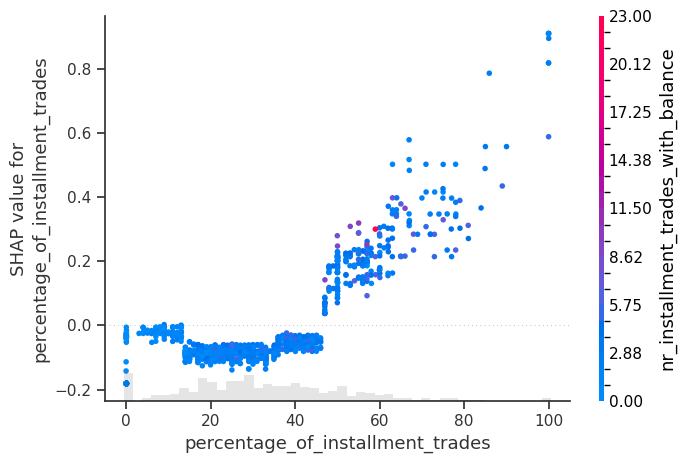

In [ ]:
shap.plots.scatter(shap_values[:, "percentage_of_installment_trades"], color=shap_values[:, 'nr_installment_trades_with_balance'])

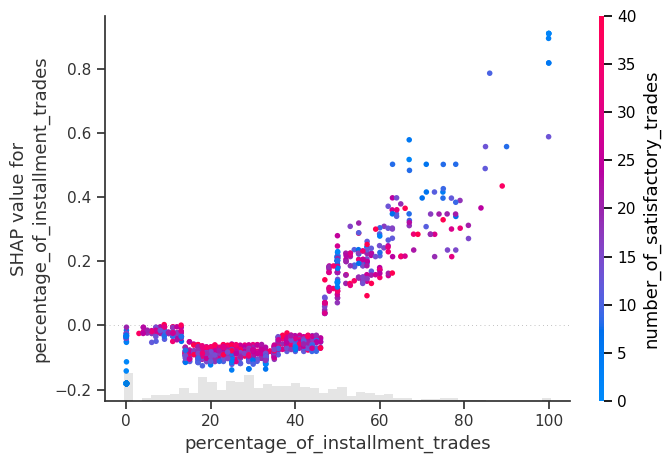

In [23]:
shap.plots.scatter(shap_values[:, "percentage_of_installment_trades"], color=shap_values[:, 'number_of_satisfactory_trades'])